In [41]:
import pandas as pd
import torch
import numpy as np
from tqdm import tqdm
import seaborn as sns

  0%|          | 0/30001 [25:17<?, ?it/s]


In [40]:
bdb = pd.read_csv('BDB_Final.csv')

In [75]:
bdb = bdb[bdb['IC50 (nM)'] < 6000] 

In [128]:
def categorize_label(label):
    if label < 10:
        return -1
    elif 10 <= label <= 1000:
        return 0
    else:
        return 1

In [129]:
bdb['Af_category'] = bdb['IC50 (nM)'].apply(categorize_label)

/tmp/ipykernel_673/607442072.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bdb['Af_category'] = bdb['IC50 (nM)'].apply(categorize_label)


In [130]:
bdb['Af_category'].value_counts()

Af_category
 1    18440
 0    17497
-1     4630
Name: count, dtype: int64

In [131]:
embeddings = []
embed_indices = []

In [132]:
base_path = 'ESM_Embeddings_New/'

In [133]:
i = 0
j = 0
for index, row in tqdm(bdb.iterrows()):
    curr_name = row['Protein index']
    try: 
        embed = torch.load(base_path + str(curr_name) + '.pt')['mean_representations'][36].numpy()
        embeddings.append(embed)
        embed_indices.append(index)
        i += 1
    except: 
        continue
    if i > 30000: 
        break

30000it [00:41, 731.36it/s]


In [134]:
embed_s = pd.Series(embeddings)
embed_indices = pd.Series(embed_indices)
subset = pd.DataFrame({'Embeddings':embed_s, 'Embed_indices':embed_indices})

In [135]:
subset['Protein index'] = subset['Embed_indices']

In [136]:
full_data = pd.merge(bdb, subset, on='Protein index')

In [137]:
full_data['Protein Embeddings'] = full_data['Embeddings']

In [138]:
labels = full_data['IC50 (nM)']

In [139]:
ligand_S = full_data['Ligand SMILES']

In [140]:
smiles = np.load('MolecularTransformerEmbeddings/embeddings/smile_values.npz')

In [141]:
mol_embed_list = []
for ligand in ligand_S.to_list(): 
    curr_array = smiles[ligand]
    curr_array = np.mean(curr_array, axis=0)
    mol_embed_list.append(curr_array)

In [142]:
prot_embed = np.array(full_data['Protein Embeddings'])

In [224]:
def pad(arr): 
    target_rows = 232
    current_rows = arr.shape[0]
    if current_rows < target_rows:
        padding = np.zeros((target_rows - current_rows, 512))
        padded_arr = np.vstack((arr, padding))
    else:
        padded_arr = arr  # or slice if needed
    return padded_arr.flatten()

In [83]:
"""
mol_flat = mol_embed[0]
for arr in tqdm(mol_embed[1:]): 
    arr = pad(arr)
    arr = np.row_stack((mol_flat, arr)) 
    """

'\nmol_flat = mol_embed[0]\nfor arr in tqdm(mol_embed[1:]): \n    arr = pad(arr)\n    arr = np.row_stack((mol_flat, arr)) \n    '

In [82]:
#mol_flat = [pad(arr) for arr in tqdm(mol_embed)]

In [92]:
#[arr.shape for arr in mol_embed_list[:10]]

In [143]:
mol_embed_stack = np.stack(mol_embed_list)

In [144]:
mol_embed_stack.shape

(30001, 512)

In [145]:
#data.shape

In [146]:
#prot_embed = data[:, 1]

In [147]:
prot_list = [arr for arr in prot_embed]

In [148]:
prot_embed_stack = np.stack(prot_list)

In [149]:
prot_embed_stack.shape

(30001, 2560)

In [150]:
prot_embed_stack.shape

(30001, 2560)

In [151]:
mol_embed_stack.shape

(30001, 512)

In [152]:
array_data = np.hstack((prot_embed_stack, mol_embed_stack))

In [153]:
np.savez('X_filtered_cat.npz', array_data)

In [154]:
labels = full_data['Af_category']

In [156]:
np.savez('y_30k_cat.npz', labels)

In [273]:
labels.shape

(30001,)

In [275]:
full_data.shape

(30001, 121344)

In [276]:
!pip install scikit-learn

In [277]:
import sklearn

In [278]:
sv = np.linalg.svdvals(full_data)

AttributeError: module 'numpy.linalg' has no attribute 'svdvals'

<Axes: xlabel='IC50 (nM)', ylabel='Count'>

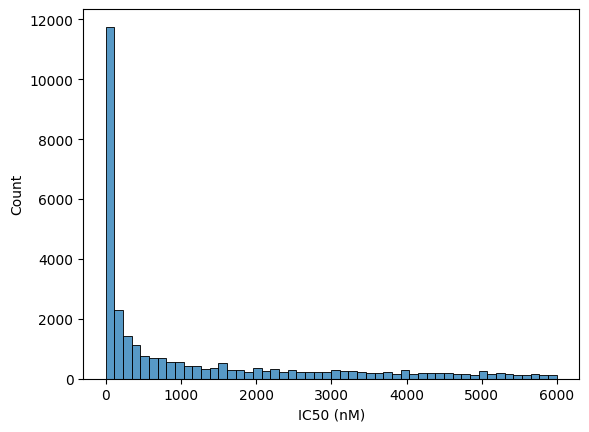

In [115]:
sns.histplot(labels)